# jina-embeddings-v4

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.7.1+cu118
11.8
True


In [ ]:
from transformers import AutoModel # carica il modello senza testa
# Carica solo il backbone del modello, cioè i pesi e i layer pre-addestrati per generare rappresentazioni (embedding).

# Non aggiunge automaticamente una testa specifica per un task: per esempio non ha la testa di language modeling, classification o question answering.

model = AutoModel.from_pretrained("jinaai/jina-embeddings-v4", trust_remote_code=True)

model.to("cuda")

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): JinaEmbeddingsV4Model(
      (model): Qwen2_5_VLModel(
        (visual): Qwen2_5_VisionTransformerPretrainedModel(
          (patch_embed): Qwen2_5_VisionPatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2_5_VLVisionBlock(
              (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
              (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
              (attn): Qwen2_5_VLVisionSdpaAttention(
                (qkv): Linear(in_features=1280, out_features=3840, bias=True)
                (proj): Linear(in_features=1280, out_features=1280, bias=True)
              )
              (mlp): Qwen2_5_VLMLP(
                (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
                (up_proj): Linear(in_features=1280, out_feat

## Get Text & Image Embeddings for Retrieval

Prendiamo gli embeddings da immagini e testo per fare un retrieval.

Di seguito mostriamo come matchano il testo (in varie lingue) e le immagini.

Si calcolano gli embedding dei testi e delle immagini, per il semplice retrieval task, e calcoliamo la similarità coseno tra gli embeddings dei testi testo e gli emebdding delle immagini.

In [4]:
import numpy as np
from transformers import AutoModel
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


# Multilingual sci-fi quotes (e.g., "May the Force be with you")
texts = [
    "May the Force be with you",  # English
    "Que la Fuerza te acompañe",  # Spanish
    "フォースと共にあらんことを",  # Japanese
    "Que a Força esteja com você",  # Portuguese
    "Möge die Macht mit dir sein",  # German
    "دع القوة تكون معك",  # Arabic
]

# Images of sci-fi movie scenes
image_urls = [
    "https://i.ibb.co/bgBNfMgH/starwars-lightsaber.jpg",  # Star Wars lightsaber duel
    "https://i.ibb.co/B2bNB4Sd/matrix-code.jpg",  # Matrix code rain
    "https://i.ibb.co/hxJLbTNW/bladerunner-city.jpg",  # Blade Runner cityscape
]

# Encode text for retrieval
text_embeddings = model.encode_text(
    texts=texts,
    task="retrieval",
    prompt_name="query",
    return_numpy=True
)

# Encode images for retrieval
image_embeddings = model.encode_image(
    images=image_urls,
    task="retrieval",
    return_numpy=True
)

print("Text Embeddings Shape:", text_embeddings.shape)

Encoding images...: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

Text Embeddings Shape: (6, 2048)


In [6]:
print("Image Embeddings Shape:", image_embeddings.shape)
print(image_embeddings[0])

Image Embeddings Shape: (3, 2048)
[-0.01775405 -0.01030031  0.04554177 ... -0.020987    0.0161973
 -0.00305525]


Similarity Scores (Text vs. Images):

Quote: May the Force be with you
  Image 1 (https://i.ibb.co/bgBNfMgH/starwars-lightsaber.jpg): 0.5866
  Image 2 (https://i.ibb.co/B2bNB4Sd/matrix-code.jpg): 0.4457
  Image 3 (https://i.ibb.co/hxJLbTNW/bladerunner-city.jpg): 0.4055

Quote: Que la Fuerza te acompañe
  Image 1 (https://i.ibb.co/bgBNfMgH/starwars-lightsaber.jpg): 0.3310
  Image 2 (https://i.ibb.co/B2bNB4Sd/matrix-code.jpg): 0.2956
  Image 3 (https://i.ibb.co/hxJLbTNW/bladerunner-city.jpg): 0.2799

Quote: フォースと共にあらんことを
  Image 1 (https://i.ibb.co/bgBNfMgH/starwars-lightsaber.jpg): 0.3467
  Image 2 (https://i.ibb.co/B2bNB4Sd/matrix-code.jpg): 0.2667
  Image 3 (https://i.ibb.co/hxJLbTNW/bladerunner-city.jpg): 0.2704

Quote: Que a Força esteja com você
  Image 1 (https://i.ibb.co/bgBNfMgH/starwars-lightsaber.jpg): 0.3987
  Image 2 (https://i.ibb.co/B2bNB4Sd/matrix-code.jpg): 0.3340
  Image 3 (https://i.ibb.co/hxJLbTNW/bladerunner-city.jpg): 0.3340

Quote: Möge die Macht mit dir sein
  Ima

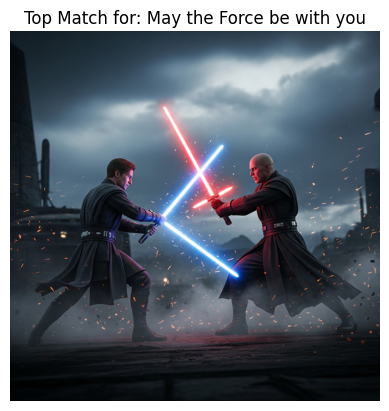

In [7]:
# Compute cosine similarity between text and image embeddings
def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b.T) / (np.linalg.norm(a, axis=1)[:, None] * np.linalg.norm(b, axis=1))

similarities = cosine_similarity(text_embeddings, image_embeddings)

# Display results
print("Similarity Scores (Text vs. Images):")
for i, text in enumerate(texts):
    print(f"\nQuote: {text}")
    for j, url in enumerate(image_urls):
        print(f"  Image {j+1} ({url}): {similarities[i][j]:.4f}")

# Visualize top match for first quote
top_image_idx = np.argmax(similarities[0])
response = requests.get(image_urls[top_image_idx])
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.title(f"Top Match for: {texts[0]}")
plt.axis("off")
plt.show()

Vediamo quindi che matchanon il significato dei testi e della immagine di star wars.



## Get text embedding for text matching

In [17]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# --- A Curated Multimodal, Multilingual Dataset ---
data = {
    "Cosmic Exploration": {
        "texts": ["Nebulae and distant galaxies", "L'exploration spatiale", "星际探索", "Viaje a las estrellas"],
        "images": ["https://i.ibb.co/B5ZNstC9/galaxy.jpg", "https://i.ibb.co/WNBkxR2v/astronaut.jpg"]
    },
    "Deep Sea Biology": {
        "texts": ["Bioluminescent creatures of the deep", "La vida en las fosas abisales", "深海生物", "Tiefseeforschung"],
        "images": ["https://i.ibb.co/LzvH2YKg/jellyfish.jpg", "https://i.ibb.co/yFxk6MrN/anglerfish.jpg"]
    },
    "Architectural Marvels": {
        "texts": ["Modernist architecture", "Готическая архитектура", "未来派の建物", "Ancient Roman structures"],
        "images": ["https://i.ibb.co/zTsKJKLH/modern-architecture.jpg", "https://i.ibb.co/Zp95cW2c/gothic-cathedral.jpg"]
    }
}

# --- Prepare for Embedding ---
all_texts = []
all_images = []
labels_texts = []
labels_images = []

for concept, content in data.items():
    all_texts.extend(content["texts"])
    all_images.extend(content["images"])
    labels_texts.extend([concept] * len(content["texts"]))
    labels_images.extend([concept] * len(content["images"]))

labels = labels_texts + labels_images
types = ['text'] * len(labels_texts) + ['image'] * len(labels_images)


print(all_texts)
print(all_images)
print(labels_texts)
print(labels_images)

['Nebulae and distant galaxies', "L'exploration spatiale", '星际探索', 'Viaje a las estrellas', 'Bioluminescent creatures of the deep', 'La vida en las fosas abisales', '深海生物', 'Tiefseeforschung', 'Modernist architecture', 'Готическая архитектура', '未来派の建物', 'Ancient Roman structures']
['https://i.ibb.co/B5ZNstC9/galaxy.jpg', 'https://i.ibb.co/WNBkxR2v/astronaut.jpg', 'https://i.ibb.co/LzvH2YKg/jellyfish.jpg', 'https://i.ibb.co/yFxk6MrN/anglerfish.jpg', 'https://i.ibb.co/zTsKJKLH/modern-architecture.jpg', 'https://i.ibb.co/Zp95cW2c/gothic-cathedral.jpg']
['Cosmic Exploration', 'Cosmic Exploration', 'Cosmic Exploration', 'Cosmic Exploration', 'Deep Sea Biology', 'Deep Sea Biology', 'Deep Sea Biology', 'Deep Sea Biology', 'Architectural Marvels', 'Architectural Marvels', 'Architectural Marvels', 'Architectural Marvels']
['Cosmic Exploration', 'Cosmic Exploration', 'Deep Sea Biology', 'Deep Sea Biology', 'Architectural Marvels', 'Architectural Marvels']


In [18]:
# --- Get the Embeddings ---
text_embeddings = model.encode_text(texts=all_texts, task="retrieval", return_numpy=True)
image_embeddings = model.encode_image(images=all_images, task="retrieval", return_numpy=True)

print("Text Embeddings Shape:", text_embeddings.shape)
print("Image Embeddings Shape:", image_embeddings.shape)
print(text_embeddings[0])
print(image_embeddings[0])

Encoding images...: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]

Text Embeddings Shape: (12, 2048)
Image Embeddings Shape: (6, 2048)
[ 0.03012422 -0.02701861  0.06294846 ... -0.02848737  0.00114468
 -0.00110415]
[ 0.00878063 -0.01794453  0.05913647 ... -0.01662975 -0.01504856
  0.01069563]


In [19]:
# --- Combine and Reduce Dimensionality ---
all_embeddings = np.concatenate([text_embeddings, image_embeddings])
print("All Embeddings Shape:", all_embeddings.shape)

All Embeddings Shape: (18, 2048)


### 📌 **1️⃣ `np.concatenate([text_embeddings, image_embeddings])`**

* **Combina** due insiemi di vettori:

  * `text_embeddings`: embedding testuali (es. da BERT, Jina, ecc.)
  * `image_embeddings`: embedding visivi (es. da CLIP, ViT, ecc.)
* `np.concatenate` li mette **uno sotto l’altro**, formando una matrice di dimensione `(N, D)`:

  * `N` = numero totale di embedding
  * `D` = dimensione dello spazio embedding originale (es. 512, 768, ecc.)

---

### 📌 **2️⃣ `TSNE(n_components=2, perplexity=5, random_state=42)`**

* Crea un oggetto **t-SNE**, un algoritmo di **riduzione dimensionale non lineare**.
* Parametri:

  * `n_components=2` → riduce gli embedding ad uno spazio bidimensionale → serve per **visualizzare** i punti in un grafico 2D.
  * `perplexity=5` → regola quanto t-SNE bilancia vicini locali vs globali (valori comuni: 5–50).
  * `random_state=42` → rende i risultati **riproducibili**.

---

### 📌 **3️⃣ `tsne.fit_transform(all_embeddings)`**

* Applica t-SNE:

  * Prende la matrice di embedding alta dimensione `(N, D)`.
  * La proietta in 2 dimensioni `(N, 2)`.
* Restituisce `reduced_embeddings` → puoi fare uno **scatter plot** per vedere come testo e immagini si distribuiscono nello spazio ridotto.

---

### 🎯 **👉 A cosa serve tutto questo?**

Serve a:

* **Combinare** embeddings multimodali (testo + immagini).
* Ridurre la dimensionalità per **visualizzare** la relazione tra i dati.
* Capire se testi e immagini simili finiscono vicini → utile per debug, paper, slide, dashboard.

---

## ✅ **Riassunto**

| Cosa fa                      | Perché serve                        |
| ---------------------------- | ----------------------------------- |
| Combina embeddings           | Unisce features multimodali         |
| Applica t-SNE                | Riduce da D-dim a 2D                |
| Ottieni `reduced_embeddings` | Pronti per `plt.scatter` o `plotly` |

In [20]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced_embeddings = tsne.fit_transform(all_embeddings)

print("Reduced Embeddings Shape:", reduced_embeddings.shape)

Reduced Embeddings Shape: (18, 2)


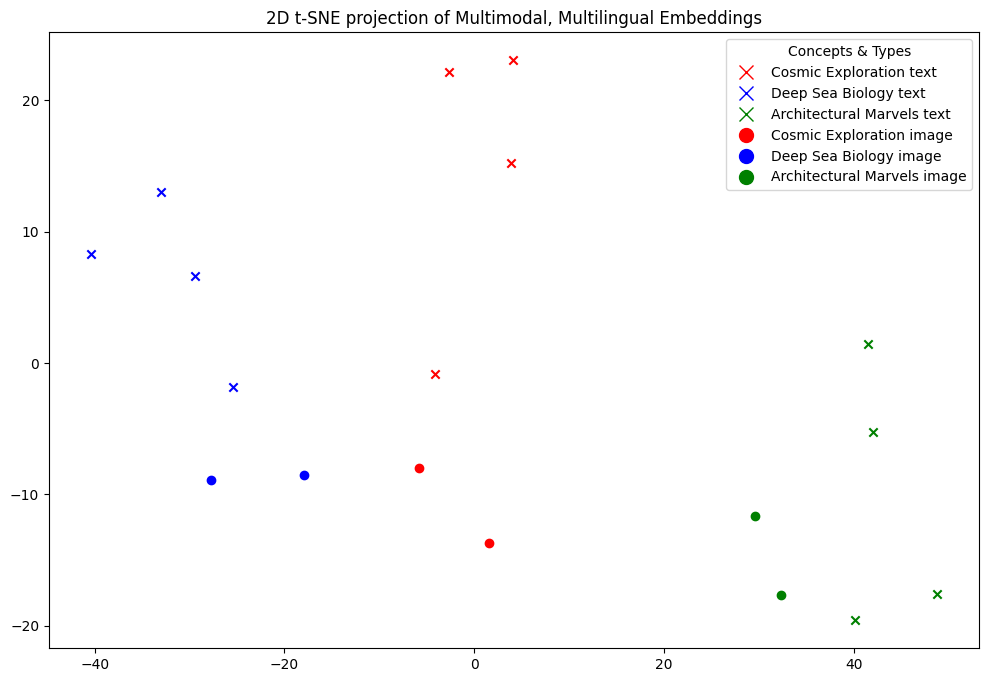

In [21]:
# --- The Clean Visualization ---
plt.figure(figsize=(12, 8))
colors = {
    'Cosmic Exploration': 'r',
    'Deep Sea Biology': 'b',
    'Architectural Marvels': 'g'
}

# Plot texts as 'x' and images as 'o'
for embedding, label, typ in zip(reduced_embeddings, labels, types):
    marker = 'x' if typ == 'text' else 'o'
    plt.scatter(
        embedding[0], embedding[1],
        c=colors[label],
        marker=marker,
        label=f"{label} {typ}"
    )

# Deduplicate labels for legend
handles = []
seen = set()
for label, typ in zip(labels, types):
    key = (label, typ)
    if key not in seen:
        marker = 'x' if typ == 'text' else 'o'
        handles.append(
            plt.Line2D(
                [0], [0],
                marker=marker,
                color='w',
                label=f"{label} {typ}",
                markerfacecolor=colors[label],
                markeredgecolor=colors[label],
                markersize=10
            )
        )
        seen.add(key)

plt.legend(handles=handles, title="Concepts & Types")
plt.title("2D t-SNE projection of Multimodal, Multilingual Embeddings")
plt.show()

# Get Text Embeddings for Codes Retrieval

In [22]:
code_snippets = [
    """
def calculate_fibonacci(n):
    a, b = 0, 1
    for _ in range(n):
        yield a
        a, b = b, a + b
    """,
    """
import numpy as np
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))
    """,
    """
import json
def save_to_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)
    """
]

# --- Multilingual "Developer" Queries ---
dev_queries = [
    "une fonction pour sauvegarder des données dans un fichier json", # French: a function to save data to a json file
    "計算フィボナッチ数列の関数", # Japanese: function to calculate the Fibonacci sequence
    "функция для вычисления средней абсолютной ошибки", # Russian: function to calculate mean absolute error
    "eine Funktion, die eine Sequenz von Fibonacci-Zahlen erzeugt" # German: a function that generates a sequence of Fibonacci numbers
]


# Here, we treat code as text, but the principle is the same.
code_embeddings = model.encode_text(texts=code_snippets, task="retrieval", return_numpy=True)
query_embeddings = model.encode_text(texts=dev_queries, task="retrieval", prompt_name="query", return_numpy=True)

print("Code Embeddings Shape:", code_embeddings.shape)
print("Query Embeddings Shape:", query_embeddings.shape)

Encoding texts...: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]

Code Embeddings Shape: (3, 2048)
Query Embeddings Shape: (4, 2048)


In [23]:
# Compute cosine similarity between texts and code snippets
def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b.T) / (np.linalg.norm(a, axis=1)[:, None] * np.linalg.norm(b, axis=1))

similarities = cosine_similarity(query_embeddings, code_embeddings)

# Display results
print("Similarity Scores (Text vs. Images):")
for i, text in enumerate(dev_queries):
    print(f"\nQuery: {text}")
    for j, cs in enumerate(code_snippets):
        print(f"  Code snippet {j+1} ({cs}): {similarities[i][j]:.4f}")

Similarity Scores (Text vs. Images):

Query: une fonction pour sauvegarder des données dans un fichier json
  Code snippet 1 (
def calculate_fibonacci(n):
    a, b = 0, 1
    for _ in range(n):
        yield a
        a, b = b, a + b
    ): 0.4437
  Code snippet 2 (
import numpy as np
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))
    ): 0.3953
  Code snippet 3 (
import json
def save_to_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)
    ): 0.7842

Query: 計算フィボナッチ数列の関数
  Code snippet 1 (
def calculate_fibonacci(n):
    a, b = 0, 1
    for _ in range(n):
        yield a
        a, b = b, a + b
    ): 0.6443
  Code snippet 2 (
import numpy as np
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))
    ): 0.3790
  Code snippet 3 (
import json
def save_to_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f

# Get Multivectors for Text and Images Retrieval

In [27]:
texts = [
    "May the Force be with you",  # English
    "Que la Fuerza te acompañe",  # Spanish
    "フォースと共にあらんことを",  # Japanese
    "Que a Força esteja com você",  # Portuguese
    "Möge die Macht mit dir sein",  # German
    "دع القوة تكون معك",  # Arabic
]

# Images of sci-fi movie scenes
images = [
    "https://i.ibb.co/bgBNfMgH/starwars-lightsaber.jpg",  # Star Wars lightsaber duel
    "https://i.ibb.co/B2bNB4Sd/matrix-code.jpg",  # Matrix code rain
    "https://i.ibb.co/hxJLbTNW/bladerunner-city.jpg",  # Blade Runner cityscape
]


# Danno in output una lista di tensori pytorch

multivector_text_embeddings = model.encode_text(
    texts=texts,
    task="retrieval",
    return_multivector=True,
)

multivector_image_embeddings = model.encode_image(
    images=images,
    task="retrieval",
    return_multivector=True,
)

for i, tensor in enumerate(multivector_text_embeddings):
    print(f"Sub-vector-text {i} shape: {tensor.shape}")

for i, tensor in enumerate(multivector_image_embeddings):
    print(f"Sub-vector-image {i} shape: {tensor.shape}")

Encoding images...: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Sub-vector-text 0 shape: torch.Size([8, 128])
Sub-vector-text 1 shape: torch.Size([10, 128])
Sub-vector-text 2 shape: torch.Size([11, 128])
Sub-vector-text 3 shape: torch.Size([10, 128])
Sub-vector-text 4 shape: torch.Size([10, 128])
Sub-vector-text 5 shape: torch.Size([9, 128])
Sub-vector-image 0 shape: torch.Size([540, 128])
Sub-vector-image 1 shape: torch.Size([540, 128])
Sub-vector-image 2 shape: torch.Size([540, 128])


In [28]:
import torch
import torch.nn.functional as F

# Supponiamo queste variabili
# multivector_text_embeddings: List[Tensor]  -> lista di L_t tensors shape [N_t_i, 128]
# multivector_image_embeddings: List[Tensor] -> lista di L_i tensors shape [N_i_j, 128]

# Usare CUDA se disponibile
device = multivector_text_embeddings[0].device

def late_interaction_score(text_mv, image_mv):
    """
    Calcola il punteggio tra un multi-vector testo e immagine:
    score = sum over text tokens max_j cosine(text_i, image_j)
    """
    # Normalizzi per cosine similarity
    t_norm = F.normalize(text_mv, dim=-1)   # [N_t,128]
    i_norm = F.normalize(image_mv, dim=-1)  # [N_i,128]

    # matrice similitudine [N_t, N_i]
    sim = torch.mm(t_norm, i_norm.T)

    # per ogni token testuale prendo la similarità massima
    max_per_token, _ = sim.max(dim=1)
    return max_per_token.sum().item()

# Confronta tutte le coppie
results = []
for ti, t_mv in enumerate(multivector_text_embeddings):
    for ij, i_mv in enumerate(multivector_image_embeddings):
        score = late_interaction_score(t_mv, i_mv)
        results.append((ti, ij, score))

# Mostra punteggio più alto
best = max(results, key=lambda x: x[2])
print(f"Testo #{best[0]} e immagine #{best[1]} matchano meglio: score = {best[2]:.4f}")


Testo #1 e immagine #2 matchano meglio: score = 4.4965
